# COSC2789 Practical Data Science
# Assignment 2: Data Modeling
**Group 4**
- Name & ID here

**Goal**: To classify income range of survey respondents. 

**Performance measures** 
- Accuracy 
- Recall 
- F1 score 
- AUC ROC 

**Data description** 
*The dataset contains responses from the 2020 Stack Overflow Developer survey, which is among the largest and most comprehensive survey of software developers.*

## Task 1.1 Data Retrieving and Cleaning 

### Setting up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xg

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#ignore unneccessary warning
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Get the data
url = 'survey_results_public.csv'
survey = pd.read_csv(url, sep=',')

In [3]:
survey.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [4]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-null  object 
 13  D

In [5]:
# generate descriptive stats 
survey.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,64461.000000,45446.000000,3.482600e+04,3.475600e+04,41151.000000
mean,32554.079738,30.834111,3.190464e+242,1.037561e+05,40.782174
std,18967.442360,9.585392,inf,2.268853e+05,17.816383
min,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,16116.000000,24.000000,2.000000e+04,2.464800e+04,40.000000
50%,32231.000000,29.000000,6.300000e+04,5.404900e+04,40.000000
75%,49142.000000,35.000000,1.250000e+05,9.500000e+04,44.000000
max,65639.000000,279.000000,1.111111e+247,2.000000e+06,475.000000


In [6]:
preprocess = survey.copy()

### Missing values

In [7]:
with pd.option_context('display.max_rows', None):
  display(preprocess.isnull().sum())

Respondent                          0
MainBranch                        299
Hobbyist                           45
Age                             19015
Age1stCode                       6561
CompFreq                        24392
CompTotal                       29635
ConvertedComp                   29705
Country                           389
CurrencyDesc                    18989
CurrencySymbol                  18989
DatabaseDesireNextYear          20391
DatabaseWorkedWith              14924
DevType                         15091
EdLevel                          7030
Employment                        607
Ethnicity                       18513
Gender                          13904
JobFactors                      15112
JobSat                          19267
JobSeek                         12734
LanguageDesireNextYear          10348
LanguageWorkedWith               7083
MiscTechDesireNextYear          22082
MiscTechWorkedWith              24147
NEWCollabToolsDesireNextYear    17174
NEWCollabToo

**Mandatory columns** 

- There are a lot of missing values in columns that correspond to mandatory questions. Since no significant differences can be observed between respondents with and without missing data, it is likely that the data are **missing completely at random**. 
- As such, it is difficult to infer what the answers might be, hence we will drop the missing data on these columns 

In [8]:
# List of mandatory columns. 
# Respodent ID is assigned automatically, hence not included in this list 
mandatory_cols = ['MainBranch', 'Hobbyist', 'Country', 'CurrencyDesc', 'CurrencySymbol', 'JobSeek']
preprocess.dropna(subset=mandatory_cols, inplace=True)

# verify the change
preprocess.loc[:, mandatory_cols].isnull().sum()

MainBranch        0
Hobbyist          0
Country           0
CurrencyDesc      0
CurrencySymbol    0
JobSeek           0
dtype: int64

**Optional columns**

*Compensation*: `CompFreq`, `CompTotal`, `ConvertedComp`
- On one hand, compensation frequency must be specified in order to calculate the total compensation amount. On the other hand, it isn't very useful to know the frequency but not the amount of compensation. 
- Therefore, we will drop any entries that contain missing values on `CompFreq`, then `CompTotal`


In [9]:
compensation_cols = ['CompTotal', 'CompFreq', 'ConvertedComp']
# drop missing values for CompFreq
preprocess.dropna(subset=['CompFreq', 'CompTotal'], axis=0, inplace=True)

# verify the change
preprocess.loc[:, compensation_cols].isnull().any()

CompTotal        False
CompFreq         False
ConvertedComp     True
dtype: bool

In [10]:
# check for remaining missing values 
preprocess[preprocess.loc[:, 'ConvertedComp'].isnull() == True]

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
7370,7400,"I am not primarily a developer, but I write co...",Yes,69.0,Younger than 5 years,Yearly,1000.0,NaN,Angola,e\tCook Islands dollar,...,Easy,Too long,NaN,NaN,NaN,NaN,NaN,168.0,Less than 1 year,Less than 1 year
23788,23878,I am a developer by profession,Yes,36.0,11,Yearly,979000.0,NaN,Norway,e\tCook Islands dollar,...,Easy,Appropriate in length,No,"Computer science, computer engineering, or sof...",React.js,Angular;jQuery;React.js;Spring,Just as welcome now as I felt last year,40.0,13,25
47224,48212,"I am not primarily a developer, but I write co...",Yes,33.0,12,Monthly,10000.0,NaN,Denmark,e\tFaroese krona,...,Neither easy nor difficult,Appropriate in length,No,"A humanities discipline (such as literature, h...",Gatsby;React.js;Vue.js,ASP.NET;Drupal;Gatsby;jQuery;React.js,Somewhat less welcome now than last year,27.0,5,3
55973,57095,I am a developer by profession,Yes,NaN,18,Monthly,5000.0,NaN,India,e\tCook Islands dollar,...,Easy,Too short,No,Mathematics or statistics,Angular;Express;React.js,Angular;Express;React.js,A lot less welcome now than last year,10.0,7,2


It seems that the compensation are paid in more rare types of currency, hence the missing values on `ConvertedComp`. 
- After some research, we found that Faroese krona has the same fixed exchange rate as Danish Krone (1 to 1) and so we will fill the converted compensation based on that exchange rate. 
- For Cook Island dollar, we weren't able to find or infer the exchange rate, so the best guess is to drop them. 

In [11]:
# find the exchange rate for Danish krone 
preprocess[preprocess.loc[:, 'CurrencySymbol'] == 'DKK'].head(1)

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
755,757,I am a developer by profession,Yes,55.0,23,Monthly,80000.0,138936.0,Denmark,Danish krone,...,Easy,Appropriate in length,No,"A natural science (such as biology, chemistry,...",Angular,ASP.NET;jQuery,Just as welcome now as I felt last year,37.0,35,28


In [12]:
dkk_to_usd = 138936.0/80000.0
converted_comp = preprocess.loc[preprocess.index.isin([47224]), 'CompTotal']*dkk_to_usd

# fill the missing converted compensation  
preprocess.loc[preprocess.index.isin([47224]), 'ConvertedComp'] = converted_comp

# while we're at it, let's fix the currency symbol too 
preprocess.loc[preprocess.index.isin([47224]), 'CurrencyDesc'] = 'Faroese krona'
preprocess.loc[preprocess.index.isin([47224]), 'CurrencySymbol'] = 'KR'

In [13]:
# drop missing values for Cook Island dollar
cols_to_drop = preprocess[preprocess.loc[:, 'ConvertedComp'].isnull() == True].index.tolist()
preprocess.drop(index=cols_to_drop, inplace=True)

*Age & working hours*
- `Age` & `WorkWeekHrs`: these 2 columns are of numerical type, we will impute the missing values with median. 

In [14]:
# fill missing age and working hours with median 
med_age = preprocess['Age'].median()
med_hour = preprocess['WorkWeekHrs'].median()
preprocess.fillna({'Age':med_age, 'WorkWeekHrs':med_hour}, inplace=True)

*Remaining columns* 

- For the remaining columns, we will fill missing values with the value 'NotMentioned'. This is because these columns are of categorical type and survey respondents have the option to leave these questions blank if they wish to not answer.

In [15]:
# fill other columns with 'NotMentioned'
cat_cols = preprocess.select_dtypes(include=[object]).columns.tolist()
preprocess[cat_cols] = preprocess[cat_cols].fillna(value='NotMentioned')

In [16]:
# verify the change
with pd.option_context('display.max_rows', None):
  display(preprocess.isnull().sum())

Respondent                      0
MainBranch                      0
Hobbyist                        0
Age                             0
Age1stCode                      0
CompFreq                        0
CompTotal                       0
ConvertedComp                   0
Country                         0
CurrencyDesc                    0
CurrencySymbol                  0
DatabaseDesireNextYear          0
DatabaseWorkedWith              0
DevType                         0
EdLevel                         0
Employment                      0
Ethnicity                       0
Gender                          0
JobFactors                      0
JobSat                          0
JobSeek                         0
LanguageDesireNextYear          0
LanguageWorkedWith              0
MiscTechDesireNextYear          0
MiscTechWorkedWith              0
NEWCollabToolsDesireNextYear    0
NEWCollabToolsWorkedWith        0
NEWDevOps                       0
NEWDevOpsImpt                   0
NEWEdImpt     

### Whitespaces/string manipulation


In [17]:
# remove whitespace
preprocess = preprocess.apply(lambda x: x.str.strip() if x.dtype == "object" else x)   
# transform letter to lowercase 
preprocess = preprocess.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

### Extreme values 

In [18]:
# check for distribution 
num_cols = preprocess.select_dtypes(exclude=['object', 'bool'])
num_cols.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,33779.000000,33779.000000,3.377900e+04,3.377900e+04,33779.000000
mean,29069.657479,31.960526,3.289355e+242,1.037774e+05,40.733636
std,18621.806400,8.225053,inf,2.261110e+05,17.554454
min,8.000000,1.000000,0.000000e+00,0.000000e+00,1.000000
25%,13280.000000,26.000000,2.000000e+04,2.515150e+04,40.000000
50%,26463.000000,30.000000,6.300000e+04,5.404900e+04,40.000000
75%,47221.500000,35.000000,1.250000e+05,9.500000e+04,42.000000
max,65630.000000,279.000000,1.111111e+247,2.000000e+06,475.000000


- `Respondent` & `CompTotal`: These two columns are of little importance for our final analysis, so we will leave them as it. Specifically, `Respondent` is just the ID of survey participants, while `CompTotal` includes compensation of varied currency.
- `Age` & `WorkWeekHrs`: There are several extreme (and unreasonable) values on these two columns that we will have to deal with. For example, the maximum value for Age is 279 which is questionable. Similarly, the maximum value for number of working hours per week is 475 hours, which is wild since a week only has 168 hours. 
- `ConvertedComp`: Because we are interested in classifying income range, we will divide the values in this column into 4 categories: **< 25k, < 50k, < 100k, > 100k**

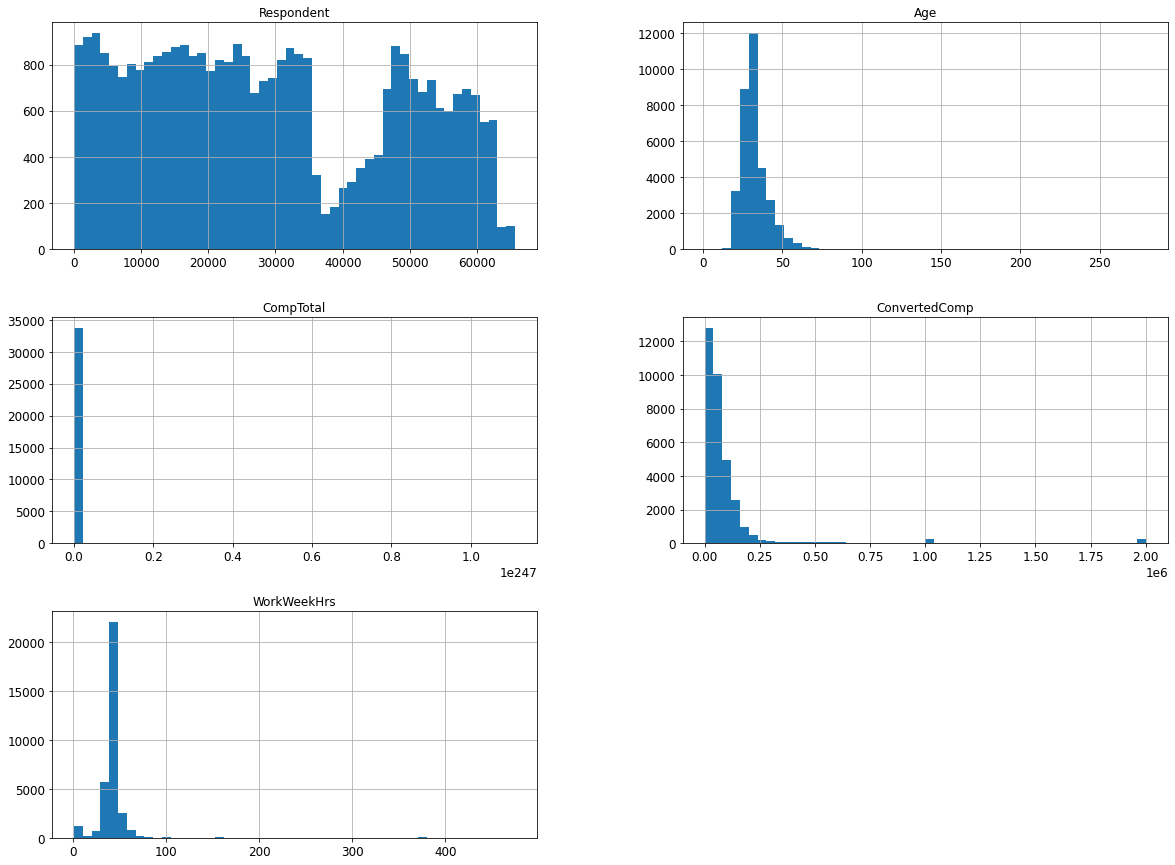

In [19]:
# Remove extreme values for Age and WorkWeekHrs
preprocess.drop(preprocess.loc[preprocess['Age']==279].index, inplace=True)
preprocess.drop(preprocess.loc[preprocess['WorkWeekHrs']>(24*7)].index, inplace=True)

# Check for distribution again 
num_cols.hist(bins=50,figsize=(20,15))
plt.show()

In [20]:
# Find the MODE value for these features: 'Age1stCode', 'YearsCode', 'YearsCodePro'
preprocess['Age1stCode'].value_counts()
preprocess['YearsCode'].value_counts()
preprocess['YearsCodePro'].value_counts()

3                     3476
2                     3378
5                     2923
4                     2696
6                     2106
10                    1987
1                     1875
8                     1707
7                     1695
less than 1 year      1381
15                    1100
12                    1095
20                    1011
9                      946
11                     759
13                     691
14                     573
16                     478
25                     397
18                     383
17                     343
22                     326
19                     283
21                     276
30                     249
23                     239
24                     182
26                     135
notmentioned           126
27                     107
35                     102
28                      92
32                      68
33                      64
34                      60
31                      59
40                      58
2

<hr>
<b><i>YearsCode</i></b> and <b><i>YearsCodePro</b></i> are 2 columns that cotain some unique value. We decide to convert <i>'less than 1 year'</i> and <i>'more than 50 years'</i> categories to numberic <i>0.5</i> and <i>51</i>. Then we replace NA value, which is <i>'notmentioned'</i> with MODE value that we calculated above for each columns. After that, we should convert all data type of 2 categories to float.
<br><br>
<b><i>Age1stCode</i></b> is also having the same kind of problem, so we repeat the same thing.
<hr>

In [21]:
# Replace highest/lowest values with the corresponding float value
# Replace 'notmentioned' values with the MODE value
preprocess['Age1stCode'] = preprocess['Age1stCode'].replace("younger than 5 years", "4")
preprocess['Age1stCode'] = preprocess['Age1stCode'].replace("older than 85", "86")
preprocess['Age1stCode'] = preprocess['Age1stCode'].replace("notmentioned", "14")

preprocess['YearsCode'] = preprocess['YearsCode'].replace("less than 1 year", "0.5")
preprocess['YearsCode'] = preprocess['YearsCode'].replace("more than 50 years", "51")
preprocess['YearsCode'] = preprocess['YearsCode'].replace("notmentioned", "10")

preprocess['YearsCodePro'] = preprocess['YearsCodePro'].replace("less than 1 year", "0.5")
preprocess['YearsCodePro'] = preprocess['YearsCodePro'].replace("more than 50 years", "51")
preprocess['YearsCodePro'] = preprocess['YearsCodePro'].replace("notmentioned", "3")

In [22]:
# Cast 'Age1stCode', 'YearsCode', 'YearsCodePro' to float type
for col in ['Age1stCode', 'YearsCode', 'YearsCodePro']:
    preprocess[col] = preprocess[col].astype('float64')

#### Handle impossible values and outliers
- The Age of Coding The First Time should not be greater than the Age
- Years of Coding Professionally should not be greater than Years of Coding
- We will drop rows that contain these impossible values

In [23]:
preprocess.drop(preprocess[preprocess['Age1stCode'] > preprocess['Age']].index, inplace = True)
preprocess.drop(preprocess[preprocess['YearsCodePro'] > preprocess['YearsCode']].index, inplace = True)

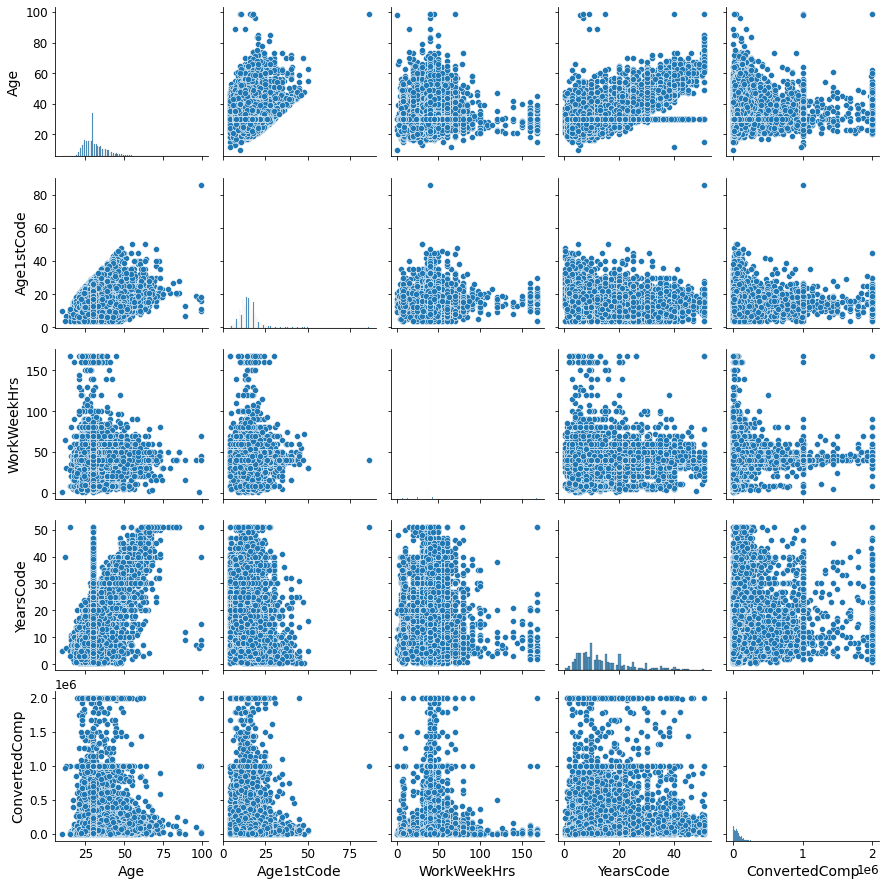

In [24]:
cols = ['Age', 'Age1stCode', 'WorkWeekHrs', 'YearsCode', 'ConvertedComp']
sns.pairplot(preprocess[cols], height = 2.5, kind='scatter', diag_kind='hist')

As could be seen from the scatter plot, there seems to be some outliers of 'Age' and 'Age1stCode' feature
I will drop instances with Age > 80 and Age1stCode > 75

In [25]:
outliers_df = preprocess.loc[(preprocess['Age'] > 80) | (preprocess['Age1stCode'] > 75)]
preprocess.drop(outliers_df.index, inplace = True)

For those instances with YearsCode > Age, we will calculate new age = YearsCode + Age1stCode, and use this new age to replace with the impossible Age value

In [26]:
preprocess[preprocess['YearsCode'] > preprocess['Age']]
preprocess.loc[preprocess['YearsCode'] > preprocess['Age'], ['Age']] = preprocess['YearsCode'] + preprocess['Age1stCode']

In [27]:
# Generate copy of ConvertedComp column
preprocess["ConvertedComp_Copy"] = preprocess["ConvertedComp"]

<AxesSubplot:>

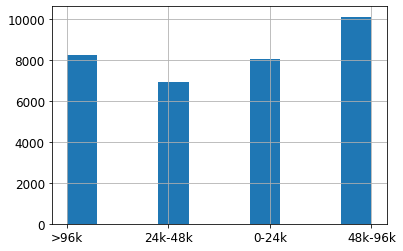

In [28]:
# Create categories for compensation
preprocess["ConvertedComp"] = pd.cut(preprocess["ConvertedComp"],
                               bins=[0, 24000, 48000, 96000, np.inf],
                               labels=['0-24k', '24k-48k', '48k-96k', '>96k'],
                               include_lowest=True)
preprocess['ConvertedComp'].hist()

In [29]:
preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33398 entries, 7 to 64153
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Respondent                    33398 non-null  int64   
 1   MainBranch                    33398 non-null  object  
 2   Hobbyist                      33398 non-null  object  
 3   Age                           33398 non-null  float64 
 4   Age1stCode                    33398 non-null  float64 
 5   CompFreq                      33398 non-null  object  
 6   CompTotal                     33398 non-null  float64 
 7   ConvertedComp                 33398 non-null  category
 8   Country                       33398 non-null  object  
 9   CurrencyDesc                  33398 non-null  object  
 10  CurrencySymbol                33398 non-null  object  
 11  DatabaseDesireNextYear        33398 non-null  object  
 12  DatabaseWorkedWith            33398 non-null  

## Task 1.2 Data Exploration

### Exploring individual columns

**Column 1: `Age`**

Text(0.5, 0, 'Age (years)')

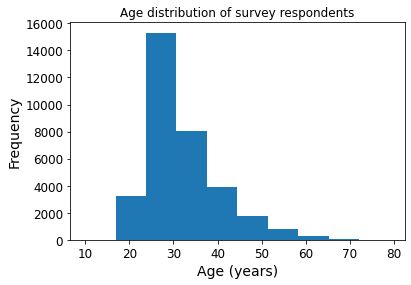

In [30]:
preprocess['Age'].plot(kind='hist')
plt.title('Age distribution of survey respondents')
plt.xlabel('Age (years)')

**Justification for graph type**: For this dataset, the `Age` column takes the form of numberical data and on a continous scale. Therefore, a historgram is chosen to visualise the distribution of such data. 

**Observation**: 
- As can be seen from the graph, age seems to have right skew distribution
- The age range is between 10 to 70 years approximately
- Majority of survey respondents aged between 20 to 40 years


**Column 2: `Employment`**

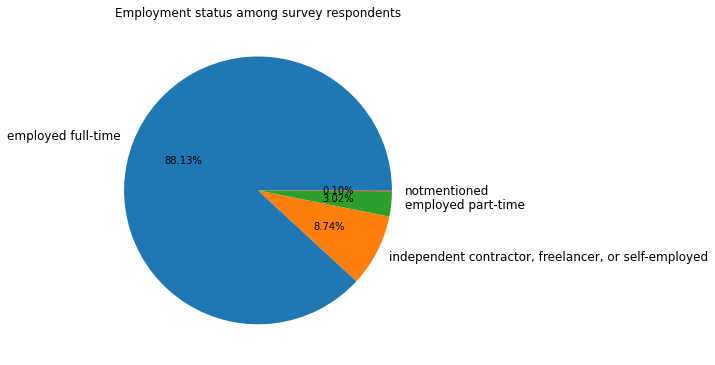

In [31]:
fig, ax = plt.subplots(figsize=(6,8))
ax.set_title('Employment status among survey respondents')
preprocess['Employment'].value_counts().plot(kind='pie', legend=False, ax=ax, autopct='%1.2f%%')
ax.set_ylabel(None)
plt.show()

**Justification for graph type**: `Employment` column is of categorical type as it contains 4 unique values representing 4 different categories. These categories is most appropriately represented by a bar chart. 

**Observation**
- Most survey respondents are employed on a full-time basis
- Only a small fraction of the respondents identified as self-employed or freelancing, followed by part-time basis 

**Column 3: `UndergradMajor`**

Text(0, 0.5, 'Major')

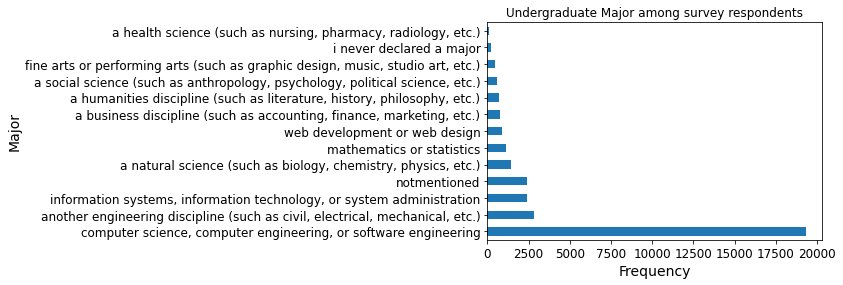

In [32]:
preprocess['UndergradMajor'].value_counts().plot(kind='barh')
plt.title('Undergraduate Major among survey respondents')
plt.xlabel('Frequency')
plt.ylabel('Major')

**Justification for graph type**: column `UndergradMajor` is also of categorical type, so a bar chart was chosen to represent the categories. 

**Observation**: 
- Most survey respondents took Computer Science/Software Engineering as their undergraduate major, followed by other Engineering disciplines and Information technology/Information system. This is understandable since developers are the main target audience of this survey. 
- We also see survey repondents coming from less technical backgrounds such as social/natural/health science and fine arts.

### Exploring relationships between columns/attributes

**Column Pair 1: `JobFactors` and `Gender`**

In [33]:
# generate dummy variables for DevType and save as dataframe
jobfact = preprocess['JobFactors'].str.get_dummies(sep=';')

# merge devtype with compensation 
jobfact_gender = jobfact.join(preprocess['Gender'])

# exclude those who did not mention their job
jobfact_gender = jobfact_gender.drop(jobfact_gender[(jobfact.notmentioned == 1)].index)
jobfact_gender.drop(columns='notmentioned', inplace=True)

In [34]:
jobfact_gender

,diversity of the company or organization,family friendliness,financial performance or funding status of the company or organization,flex time or a flexible schedule,how widely used or impactful my work output would be,industry that i’d be working in,"languages, frameworks, and other technologies i’d be working with",office environment or company culture,opportunities for professional development,remote work options,specific department or team i’d be working on,Gender
7,0,1,0,0,0,0,0,0,1,1,0,man
9,0,0,0,1,1,0,0,0,1,0,0,man
10,0,0,0,1,0,0,1,0,0,1,0,man
11,0,1,0,0,0,0,0,1,0,1,0,man
12,0,0,1,0,0,1,0,1,0,0,0,man
...,...,...,...,...,...,...,...,...,...,...,...,...
64100,0,0,0,0,1,0,0,0,1,1,0,notmentioned
64111,0,0,0,0,0,0,0,1,0,0,0,man
64148,0,0,0,0,0,1,1,0,1,0,0,notmentioned
64152,0,0,0,1,0,0,1,0,0,1,0,man


In [35]:
# Utility function 
def counts_per_group(df, col, group, options): 
    # select the factors for the current income category 
    values = df[df.loc[:, col] == group]
    # count the number of jobs for this category 
    d = {}
    for option in options: 
        count = values[option].sum(axis=0)
        d[option] = count
    d = dict(sorted(d.items(), key=lambda item: item[1]))
    # return as dataframe
    results = pd.DataFrame(list(d.items())[:])
    results = results.set_index(0)
    return results

In [36]:
# get a list of job factors to check
factors = jobfact_gender.columns.tolist() 
factors.remove("Gender")

jobfactors_man = counts_per_group(jobfact_gender, 'Gender', 'man', factors)
jobfactors_woman = counts_per_group(jobfact_gender, 'Gender', 'woman', factors)
jobfactors_nonbinary = counts_per_group(jobfact_gender, 'Gender', 'non-binary, genderqueer, or gender non-conforming', factors)

In [37]:
jobfactors_man

,1
0,
diversity of the company or organization,1469
specific department or team i’d be working on,3251
financial performance or funding status of the company or organization,3264
family friendliness,3453
industry that i’d be working in,4155
how widely used or impactful my work output would be,6013
remote work options,10129
opportunities for professional development,11573
flex time or a flexible schedule,13043


<AxesSubplot:title={'center':'Non-binary, genderqueer, or gender non-conforming'}, ylabel='0'>

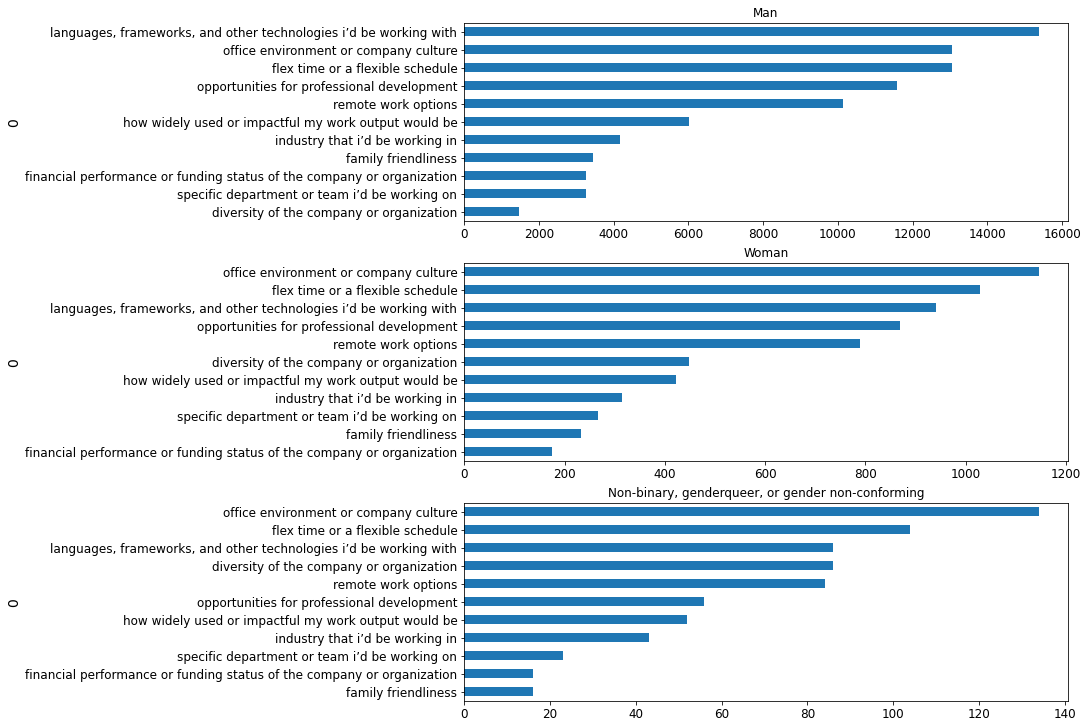

In [38]:
# plot the data
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10), constrained_layout=True) 

jobfactors_man.plot(ax=axes[0], kind='barh', legend=False, title='Man')
jobfactors_woman.plot(ax=axes[1], kind='barh', legend=False, title='Woman')
jobfactors_nonbinary.plot(ax=axes[2], kind='barh', legend=False, title='Non-binary, genderqueer, or gender non-conforming')

**Hypothesis**
- We hypothesise that different genders might hold different values and workplace expectations. In particular, we would like to explore what is considered to be most important job factors between different genders. 

**Discussion**
- As can be seen from the graph, having flexibile work time/schedule is the second most important job factor among the three gender representations. 
- Majority of male survey respondents consider the language/framework they work with to be most important job factor. On the contrary, female and non-binary/genderqueer/gender non-conforming respondents identify office environment and company culture to be most important. 
- These observations confirm our hypothesis and speak to the diveristy in gender and psychosocial workplace factors. 


**Pair 2: `DevType` and `ConvertedComp`**

In [39]:
# generate dummy variables for DevType and save as dataframe
dev = preprocess['DevType'].str.get_dummies(sep=';')

# merge devtype with compensation 
dev_comp = dev.join(preprocess['ConvertedComp'])

# exclude those who did not mention their job
dev_comp = dev_comp.drop(dev_comp[(dev.notmentioned == 1)].index)
dev_comp.drop(columns='notmentioned', inplace=True)
dev_comp = dev_comp.applymap(int)

ValueError: invalid literal for int() with base 10: '>96k'

In [40]:
dev_comp

,academic researcher,data or business analyst,data scientist or machine learning specialist,database administrator,designer,"developer, back-end","developer, desktop or enterprise applications","developer, embedded applications or devices","developer, front-end","developer, full-stack",...,educator,"engineer, data","engineer, site reliability",engineering manager,marketing or sales professional,product manager,scientist,senior executive/vp,system administrator,ConvertedComp
7,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,>96k
9,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,24k-48k
10,0,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,24k-48k
11,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0-24k
12,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24k-48k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64100,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,48k-96k
64111,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0-24k
64148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0-24k
64152,0,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0-24k


In [41]:
# get the job titles to check
titles = dev_comp.columns.tolist() 
titles.remove("ConvertedComp")

income_cat1 = counts_per_group(dev_comp, 'ConvertedComp', 1, titles)
income_cat2 = counts_per_group(dev_comp, 'ConvertedComp', 2, titles)
income_cat3 = counts_per_group(dev_comp, 'ConvertedComp', 3, titles)
income_cat4 = counts_per_group(dev_comp, 'ConvertedComp', 4, titles)

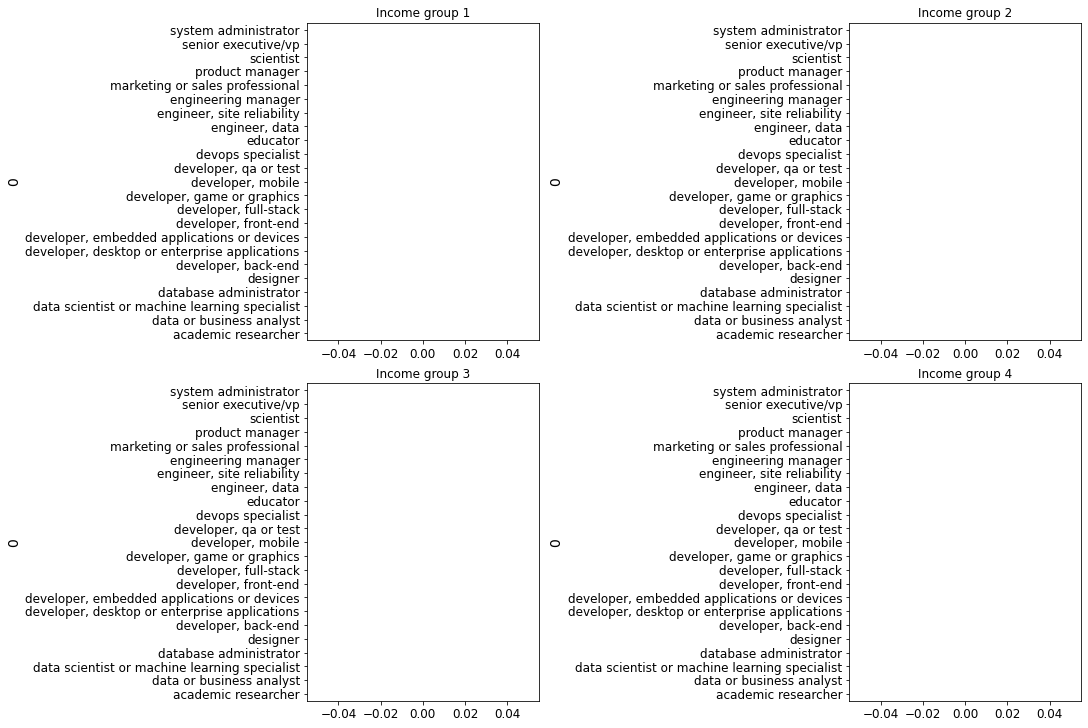

In [42]:
# plot the data 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10), constrained_layout=True) 

income_cat1.plot(ax=axes[0,0], kind='barh', legend=False)
income_cat2.plot(ax=axes[0,1], kind='barh', legend=False)
income_cat3.plot(ax=axes[1,0], kind='barh', legend=False)
income_cat4.plot(ax=axes[1,1], kind='barh', legend=False)
for i, ax in enumerate(axes.flat):
    ax.set_title(f'Income group {i+1}')

**Pair 3: `WorkWeekHrs` and `JobSat`**

In [43]:
workhrs_jobsat = preprocess.loc[:, ['WorkWeekHrs', 'JobSat']]

In [44]:
df = workhrs_jobsat[workhrs_jobsat['JobSat'].isin(['very satisfied','very dissatisfied'])]

<AxesSubplot:xlabel='WorkWeekHrs', ylabel='JobSat'>

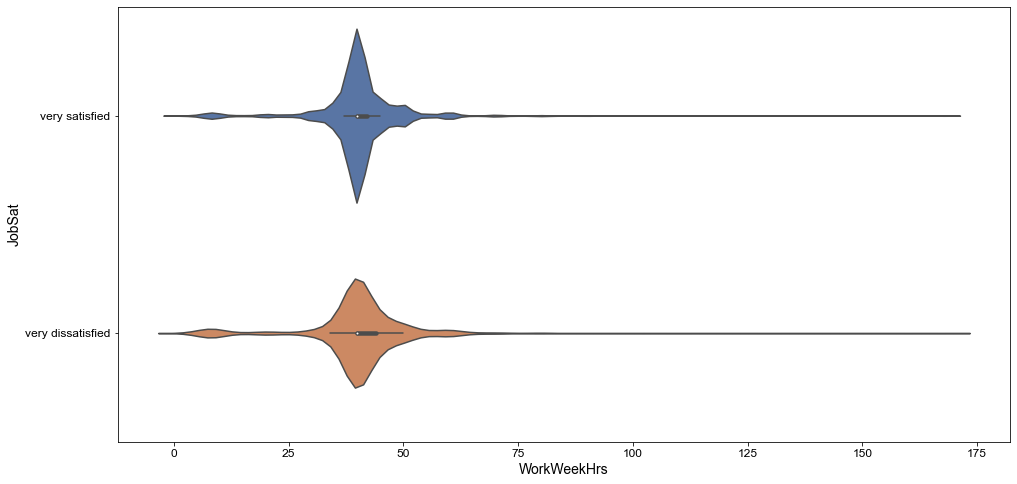

In [45]:
# plot the data
fig, ax = plt.subplots(figsize=(16, 8))
sns.set(style = 'whitegrid')   
sns.violinplot(x ='WorkWeekHrs',y ='JobSat', data = df, ax=ax)

**Hypothesis**
- There have been many research studies looking at impact of working hours on job satisfaction. As such, we hypothesise that those who work longer hours will have lower job satisfaction level due to less work-life balance.
- For the sake of simplicity and ease of comparison, we chose to visualise the two extreme ends of the satisfaction level spectrum: very satisfied and very dissatisfied

**Observation** 
- We assume that for an average person, the weekly working hours is around 40 hours.
- Looking at most dense region of the violin plot, we can see that majority survey respondents work around 40 hours per week.
- The upper adjacent values for 'very satisfied' and 'very dissatisfied' are 40 and 50 respectively. This speaks to the fact that those who feel dissatisfied at their job tends to have longer working hours. 

## <b>Task 2: Data Modeling</b>

### <b>XGBoost Preprocessing and Modeling</b>

In [46]:
df_train = pd.DataFrame(data= preprocess, columns=['Respondent','MainBranch','Age', 'Hobbyist','CompFreq','Country',
                                                   'Employment', 'ConvertedComp','DevType','EdLevel','JobSat', 'WorkWeekHrs','OpSys',
                                                   'YearsCodePro', 'YearsCode'])
df_train['Age'] =df_train['Age'].astype('int')
# df_train.loc[df_train['Age'] < 16, 'Age'] = 16
# df_train.loc[df_train['Age'] > 83, 'Age'] = 83


df_train['DevType'] = df_train['DevType'].str.split(';')
df_train = df_train.explode('DevType')
df_train= df_train.reset_index(drop=True)

In [47]:
right_df = pd.DataFrame(data= preprocess, columns=['Respondent','MainBranch','Age', 'Hobbyist','CompFreq','Country',
                                                   'Employment', 'ConvertedComp','EdLevel','JobSat', 'WorkWeekHrs','OpSys',
                                                   'YearsCodePro', 'YearsCode'])

test = pd.DataFrame(right_df, columns=['Respondent','ConvertedComp','WorkWeekHrs','YearsCodePro','YearsCode','Age'])
right_df = right_df.drop(['Respondent','ConvertedComp','WorkWeekHrs','YearsCodePro','YearsCode','Age'], axis=1)

right_df = right_df.join(pd.get_dummies(right_df, columns=['MainBranch', 'Hobbyist','Country','EdLevel','Employment', 'CompFreq', 
                                                   'OpSys','JobSat'], 
                                       prefix=['MainBranch_', 
                                                   'Hobbyist_','Country_','EdLevel_','Employment_', 'CompFreq_', 
                                                   'OpSys_','JobSat_']))
right_df = right_df.drop(['MainBranch', 'Hobbyist','Country','EdLevel','Employment', 'CompFreq', 
                                                   'OpSys','JobSat'], axis=1)
right_df= right_df.join(test)
               
left_df = pd.crosstab(df_train['Respondent'], df_train['DevType']).rename_axis(None,axis=1).add_prefix('DevType_').reset_index()

df_train_new = pd.merge(right_df,left_df, on="Respondent")

In [48]:
y = df_train_new['ConvertedComp']
train_data = df_train_new.drop(['ConvertedComp'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(train_data, y , test_size=0.2, random_state=42)

In [49]:
xgbclass =   xg.XGBClassifier(max_depth=10 ,seed=42)
xgbclass.fit(X_train, y_train,early_stopping_rounds=10 , eval_set=[(X_test, y_test)])

y_pred = xgbclass.predict(X_test)
# score = accuracy_score(y_test, y_pred)
# predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\Users\datb9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.19598
[1]	validation_0-mlogloss:1.08415
[2]	validation_0-mlogloss:1.00952
[3]	validation_0-mlogloss:0.95992
[4]	validation_0-mlogloss:0.92126
[5]	validation_0-mlogloss:0.89351
[6]	validation_0-mlogloss:0.87219
[7]	validation_0-mlogloss:0.85656
[8]	validation_0-mlogloss:0.84520
[9]	validation_0-mlogloss:0.83518
[10]	validation_0-mlogloss:0.82626
[11]	validation_0-mlogloss:0.81846
[12]	validation_0-mlogloss:0.81330
[13]	validation_0-mlogloss:0.80814
[14]	validation_0-mlogloss:0.80444
[15]	validation_0-mlogloss:0.80135
[16]	validation_0-mlogloss:0.79781
[17]	validation_0-mlogloss:0.79554
[18]	validation_0-mlogloss:0.79327
[19]	validation_0-mlogloss:0.79167

In [50]:
# Classification Report
print('\n{}'.format(classification_report(y_test, y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:\n', cm)


              precision    recall  f1-score   support

       0-24k       0.78      0.81      0.80      1618
     24k-48k       0.54      0.53      0.53      1325
     48k-96k       0.64      0.66      0.65      2044
        >96k       0.75      0.70      0.72      1693

    accuracy                           0.68      6680
   macro avg       0.68      0.68      0.68      6680
weighted avg       0.68      0.68      0.68      6680


Confusion Matrix:
 [[1316  226   55   21]
 [ 252  702  324   47]
 [  60  308 1349  327]
 [  49   73  388 1183]]


### <b>LightGBM Preprocessing and Modelling </b>

In [51]:
#backup dataframe
df = preprocess

<hr>
First of all, we want to select enough features to train the model. By having a close look into the dataframe, we might select some important features that can be helpful such as:  <b><i>MainBranch, Country, Employment, CompFreq, OpSys, OrgSize, EdLevel, ConvertedComp, WorkWeekHrs, Age, YearsCode, YearsCodePro, NEWOvertime</b></i>. 

<b><i>DevType</i></b> is also a very good feature since it can help to predict which type of developer might affect the salary the most. But before using this feature, we need to pre-process the data since it is currently very hard to train with the value.

In this case, we will divide it into each type of developer that we need, then mark it as <b><i>True</i></b> if the data contain the value. Then we set all other values as <b><i>False</i></b>. Because there are a lot of type as a <b>developer</b>: back-end, front-end, full-stack, etc., therefore we will just simply keep it as one type instead of splitting it.<hr>

In [52]:
#method to check if the user have specific role that we want
def get_DevType(type, data):
    column = 'DevType_' + type
    data['DevType_' + type]= data['DevType'].copy()
    data.loc[data[column].str.contains(type), column] = True
    data[column] = np.where(data[column].isin([True]), data[column], False)
    data[column] = data[column].astype(bool)

In [53]:
#choose which type of developer that we need
DevTypeArr = ['academic researcher', 'data or business analyst', 'data scientist or machine learning specialist', 'database administrator',
             'designer', 'developer', 'devops specialist', 'educator', 'engineer', 'engineering manager', 'marketing or sales professional', 
             'product manager', 'scientist', 'senior executive', 'system administrator']

for i in DevTypeArr:
    get_DevType(i, df)

In [54]:
#copy DevType features to new dataframe
DevType_df = df.loc[:,df.columns.str.startswith('DevType_')]

Now we can split the dataset

In [88]:
#split X, y
X = df[['MainBranch', 'Country', 'Employment', 'CompFreq', 'OpSys', 'OrgSize', 'EdLevel', 'WorkWeekHrs',
             'Age', 'YearsCode', 'YearsCodePro', 'NEWOvertime']]
y = df['ConvertedComp']

#merge devtype features with remaining data
X = pd.concat([X, DevType_df], axis=1)

Before we split into train and set data, we need to convert all columns that are object data type to category so that we can use those as category features.

In [89]:
# convert object dtype to category
for col in ['MainBranch', 'Country', 'Employment', 'CompFreq', 'OpSys', 'OrgSize', 'EdLevel', 'NEWOvertime']:
    X[col] = X[col].astype('category')

In [133]:
#StratifiedKFold splitter
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [182]:
# Parameter Tuning
para_tuning = {'num_iterations': 1000,'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'max_bin': 100,
               'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 0,
               'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
               'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31,
               'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0,
               'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 

In [183]:
# get index of categorical features
cate_feats = X_train.select_dtypes(include=['category']).columns.to_list()
cat_idx = [X_train.columns.get_loc(col) for col in cate_feats]

We are now ready to train and predict the data.

In [184]:
# build the lightgbm model
import lightgbm as lgb

clf = lgb.LGBMClassifier(**para_tuning)
clf = clf.fit(X_train, y_train, categorical_feature=cat_idx)

C:\Users\datb9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\datb9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [185]:
# predict the results
y_pred=clf.predict(X_test)

In [186]:
# evaluation
print('\n{}'.format(classification_report(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

accuracy=accuracy_score(y_pred, y_test)
print('\nLightGBM Model accuracy score: {}'.format(accuracy_score(y_test, y_pred)))


              precision    recall  f1-score   support

       0-24k       0.79      0.81      0.80      1608
     24k-48k       0.57      0.55      0.56      1389
     48k-96k       0.65      0.68      0.67      2027
        >96k       0.75      0.71      0.73      1655

    accuracy                           0.69      6679
   macro avg       0.69      0.69      0.69      6679
weighted avg       0.69      0.69      0.69      6679


Confusion Matrix
 [[1295  242   44   27]
 [ 252  760  332   45]
 [  58  255 1386  328]
 [  35   67  378 1175]]

True Positives(TP) =  1295

True Negatives(TN) =  760

False Positives(FP) =  242

False Negatives(FN) =  252

LightGBM Model accuracy score: 0.6911214253630783


#### Check for Overfitting

In [176]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9642
Test set score: 0.6940


The training and test set accuracy are quite comparable. So, we cannot say there is overfitting. 

### <b> CatBoost Preprocessing and Modelling </b>

In [64]:
import re

def count_unique_value(row):
    values = re.split(';', row)
        
    return len(values)

#### Adding some new features

In [65]:
preprocess['Database_Count'] = preprocess['DatabaseWorkedWith'].apply(lambda x: count_unique_value(x))
preprocess['Lang_Count'] = preprocess['LanguageWorkedWith'].apply(lambda x: count_unique_value(x))
preprocess['Misc_Count'] = preprocess['MiscTechWorkedWith'].apply(lambda x: count_unique_value(x))
preprocess['Platform_Count'] = preprocess['PlatformWorkedWith'].apply(lambda x: count_unique_value(x))
preprocess['Webframework_Count'] = preprocess['WebframeWorkedWith'].apply(lambda x: count_unique_value(x))
preprocess['Total_Count'] = preprocess['Database_Count'] + preprocess['Lang_Count'] + preprocess['Misc_Count'] + preprocess['Platform_Count'] + preprocess['Webframework_Count']

#### Correlation Analysis

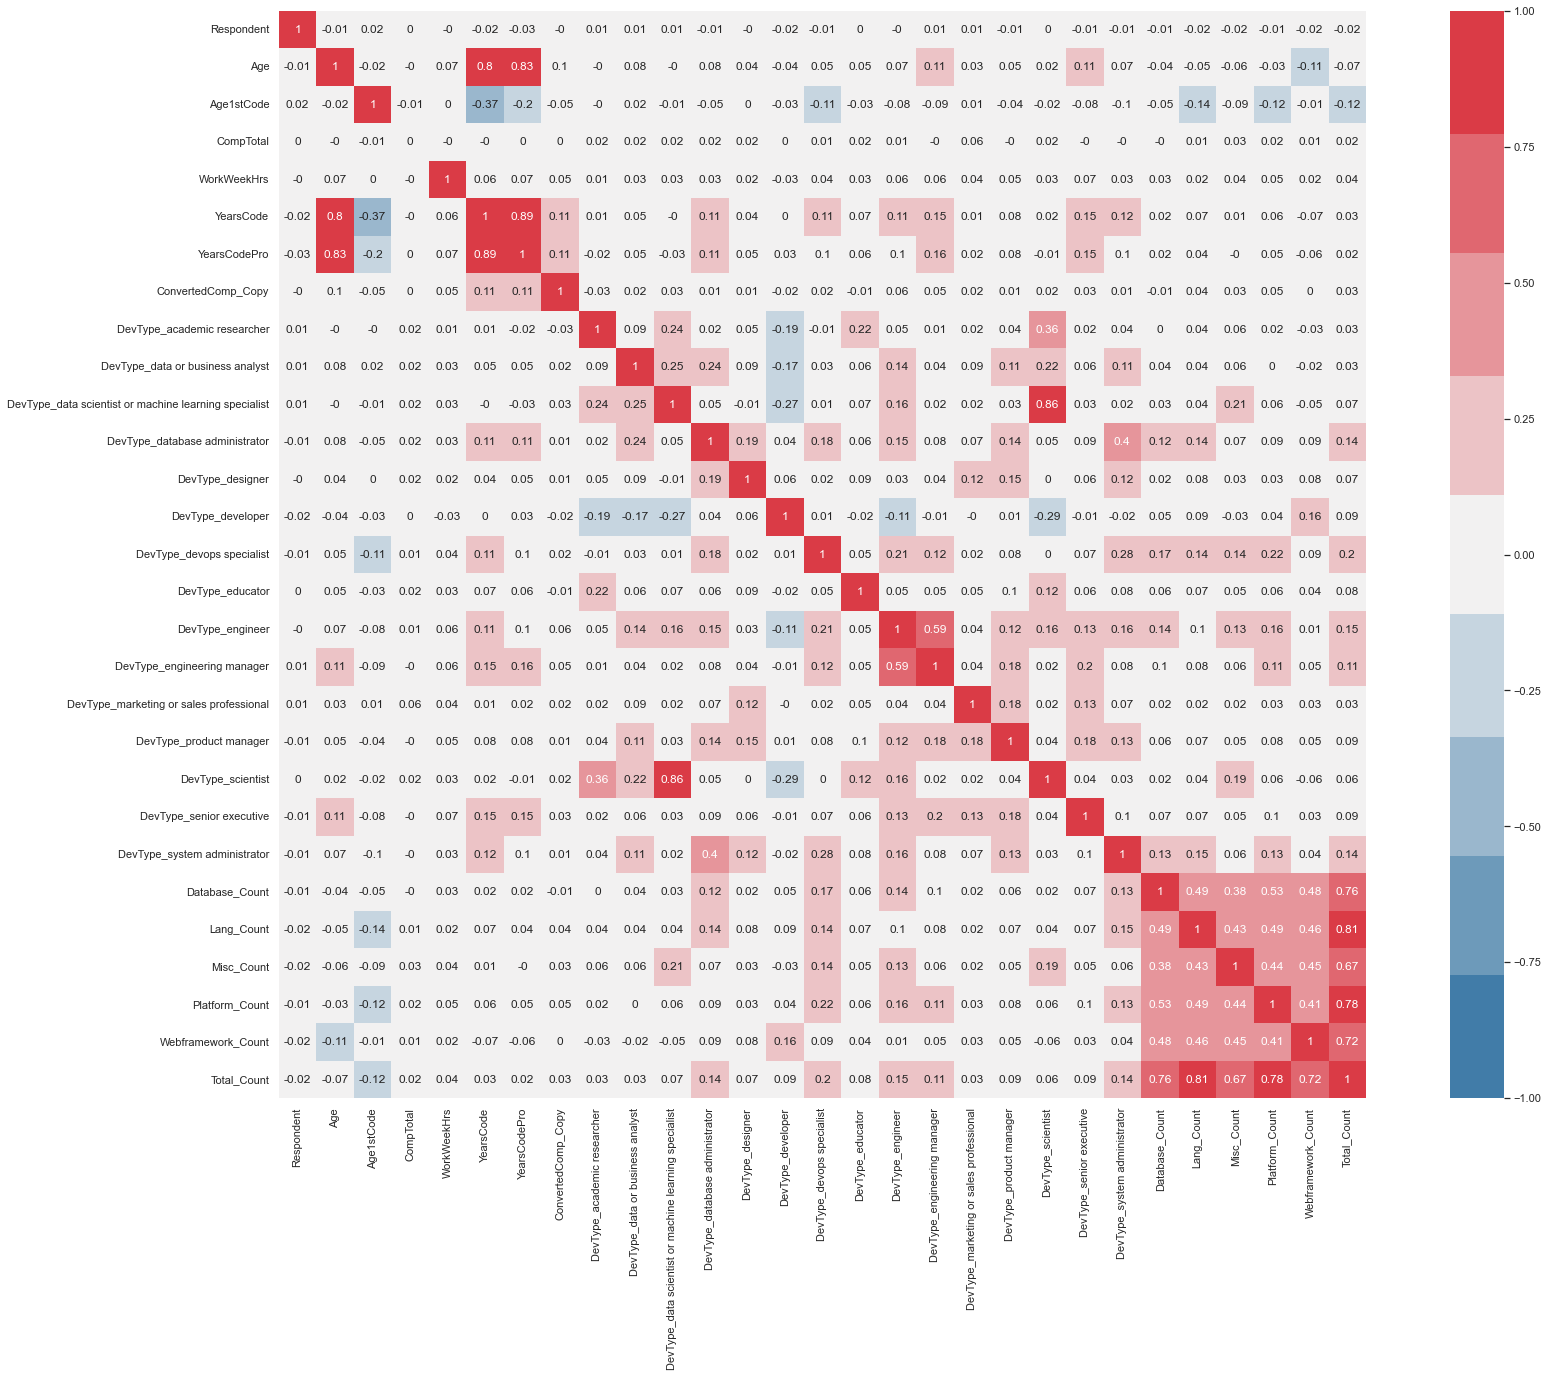

In [66]:
plt.rcParams['figure.figsize'] = (30, 20)
sns.heatmap(preprocess.corr().round(2), annot=True, vmin=-1, vmax=1, center=0,
            square=True, cmap = sns.diverging_palette(240, 10, n=9))
plt.show()

- YearsCode and YearsCodePro are highly correlated, I will use 1 feature for training model
- Respondent and CompTotal columns are not correlated to ConvertedComp, I will not use them for the training model

#### Feature selection

In [67]:
preprocess['DevType_engineer']

7        False
9        False
10       False
11       False
12       False
         ...  
64100    False
64111    False
64148    False
64152    False
64153    False
Name: DevType_engineer, Length: 33398, dtype: bool

In [68]:
cor = preprocess.corr()
# Correlation with output variable
cor_target = abs(cor["ConvertedComp_Copy"])

# Selecting highly correlated features
cor_features = cor_target[cor_target > 0.01]
num_cols = cor_features.index.to_list()
num_cols

['Age',
 'Age1stCode',
 'WorkWeekHrs',
 'YearsCode',
 'YearsCodePro',
 'ConvertedComp_Copy',
 'DevType_academic researcher',
 'DevType_data or business analyst',
 'DevType_data scientist or machine learning specialist',
 'DevType_developer',
 'DevType_devops specialist',
 'DevType_educator',
 'DevType_engineer',
 'DevType_engineering manager',
 'DevType_marketing or sales professional',
 'DevType_product manager',
 'DevType_scientist',
 'DevType_senior executive',
 'Lang_Count',
 'Misc_Count',
 'Platform_Count',
 'Total_Count']

In [69]:
num_feats = ['Age', 'Age1stCode', 'WorkWeekHrs', 'YearsCode', 'YearsCodePro', 'Lang_Count', 'Misc_Count', 'Platform_Count', 'Total_Count']

In [70]:
cate_feats = ['MainBranch',
              'Hobbyist',
              'Country', 
              'EdLevel',
              'Employment',
              'JobSat',
              'JobSeek',
              'NEWEdImpt',
              'NEWLearn',
              'NEWOffTopic',
              'NEWOtherComms',
              'NEWOvertime',
              'OpSys',
              'OrgSize',
              'PurchaseWhat',
              'SOAccount',
              'SOComm',
              'SOPartFreq',
              'SOVisitFreq',
              'UndergradMajor',
              'WelcomeChange']

# Cast some features to category types 
for col in cate_feats:
    preprocess[col] = pd.Categorical(preprocess[col])

In [71]:
ohe_cols = ['DevType', 'JobFactors', 'LanguageWorkedWith', 'PlatformWorkedWith', 'MiscTechWorkedWith', 'DatabaseWorkedWith']

In [72]:
df_data = pd.concat([preprocess['ConvertedComp'], preprocess[num_feats], preprocess[cate_feats], preprocess[ohe_cols]], axis=1)

In [73]:
# df_data.info()

#### Extract some information from text features and encoding

In [74]:
import re

def split_value(dataframe, col):
    values_dict = set()

    for index, row in dataframe.iterrows():
        values = re.split(';', row[col])
        for value in values:
            values_dict.add(value)
    return values_dict

In [75]:
ohe_cols = df_data.select_dtypes(include=['object']).columns.to_list()

In [76]:
for col in ohe_cols:
    ohe_col = split_value(df_data, col)
    for val in ohe_col:
        df_data[col + '_' + val] = np.where(df_data[col].str.contains(val, regex=False), 1, 0)

In [77]:
df_data.drop(columns=ohe_cols, inplace=True)

In [78]:
df_data.shape

(33398, 145)

#### Data Modeling

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit 
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

In [80]:
splitter= StratifiedShuffleSplit(n_splits=1, random_state=42)

X = df_data.iloc[:, 1:]
y = df_data["ConvertedComp"]

for train,test in splitter.split(X,y):
    X_train_SS = X.iloc[train]
    y_train_SS = y.iloc[train]
    X_test_SS = X.iloc[test]
    y_test_SS = y.iloc[test]

display(X_train_SS.shape, X_test_SS.shape) 

(30058, 144)

(3340, 144)

In [81]:
cate_cols = X_train_SS.select_dtypes(include=['category']).columns.to_list()
cat_idx = [X_train_SS.columns.get_loc(col) for col in cate_cols]
cat_idx

[9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [82]:
model_3 = CatBoostClassifier(
    iterations=800,
    learning_rate=0.08,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton',
    bagging_temperature=0.2, 
    reg_lambda=7.898,
    od_type='Iter',
    metric_period = 100,
    od_wait=20
)

In [83]:
model_3.fit(
    X_train_SS, y_train_SS, 
    cat_features=cat_idx,
)

0:	learn: 0.6058287	total: 816ms	remaining: 10m 52s
100:	learn: 0.7003793	total: 1m 23s	remaining: 9m 39s
200:	learn: 0.7247655	total: 2m 52s	remaining: 8m 34s
300:	learn: 0.7375408	total: 4m 21s	remaining: 7m 13s
400:	learn: 0.7510480	total: 5m 43s	remaining: 5m 42s
500:	learn: 0.7595648	total: 7m 3s	remaining: 4m 12s
600:	learn: 0.7682148	total: 8m 19s	remaining: 2m 45s
700:	learn: 0.7767317	total: 9m 37s	remaining: 1m 21s
799:	learn: 0.7846164	total: 10m 50s	remaining: 0us


In [84]:
y_pred_SS = model_3.predict(X_test_SS)

In [85]:
print('Model accuracy for train set: {0:.3f}'.format(model_3.score(X_train_SS, y_train_SS)))
print('Model accuracy for test set: {0:.3f}'.format(model_3.score(X_test_SS, y_test_SS)))

Model accuracy for train set: 0.761
Model accuracy for test set: 0.693


In [86]:
# Classification Report
print('\n{}'.format(classification_report(y_test_SS, y_pred_SS)))

# Confusion Matrix
cm = confusion_matrix(y_test_SS, y_pred_SS)
print('\nConfusion Matrix:\n', cm)

# Accuracy Score
auc = accuracy_score(y_test_SS, y_pred_SS)
print('\nAccuracy Score: ', auc.round(4))


              precision    recall  f1-score   support

       0-24k       0.80      0.81      0.80       804
     24k-48k       0.58      0.61      0.59       694
     48k-96k       0.63      0.69      0.66      1014
        >96k       0.79      0.66      0.72       828

    accuracy                           0.69      3340
   macro avg       0.70      0.69      0.69      3340
weighted avg       0.70      0.69      0.69      3340


Confusion Matrix:
 [[651 122  26   5]
 [118 421 152   3]
 [ 30 147 696 141]
 [ 15  34 234 545]]

Accuracy Score:  0.6925


### Model Selection

Let's have a look at all three models and compare them to each other. The one that have the highest accuracy is model_3: <b>CatBoost</b>.

Furthermore, when compare to the number of features that we have in each models, CatBoost is the one that has the most total of features.
<br> 

Therefore, we decide to save the CatBoost model for the <b>Deployment & Automation</b> and any future investigation.

In [87]:
# save the model to disk
import pickle
filename = 'pickle_model.pkl'
pickle.dump(model_3, open(filename, 'wb'))

## Task 3 Model deployment & automation

This part can be achieved by running <b><i>flask-app.py</i></b> file.

## Task 4 Visualisation dashboard